In [1]:
import jax.numpy as jnp
import bayes3d as b
import functools
import jax
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

I0000 00:00:1695245514.405748  301812 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7007/static/


In [26]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.001, far=1.0
)

In [27]:
b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(17).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


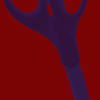

In [28]:
gt_depth = b.RENDERER.render(b.transform_from_pos(jnp.array([0.0, 0.0, 0.5]))[None,...],jnp.array([0]) )[...,2]
b.get_depth_image(gt_depth)

In [29]:

@functools.partial(
    jnp.vectorize,
    signature='(m)->()',
    excluded=(1,),
)
def get_value_at_pixel(
    ij,
    sorted_processed_ball_data
):
    T = 1.0
    far = intrinsics.far
    running_value = 0.0
    for ball_data in sorted_processed_ball_data:
        cov_x, cov_y, cov_z, cov_det, ball_x, ball_y, depth_val, opacity = ball_data
        d = jnp.array([ball_x, ball_y]) - ij
        
        power = -0.5 * (cov_x * d[0]**2 + cov_z * d[1]**2 + 2 * cov_y * d[0] * d[1])
        alpha = jnp.minimum(0.99, opacity * jnp.exp(power))
        test_T = T * (1 - alpha)

        running_value = jnp.where(jnp.logical_or(jnp.logical_or(power > 0.0, alpha < 1.0/255.0), T < 0.0001), running_value, running_value + depth_val * alpha * T)
        T = jnp.where(jnp.logical_or(jnp.logical_or(power > 0.0, alpha < 1.0/255.0), T < 0.0001), T, test_T)
    running_value += T * far
    return running_value

def process_ball(ball_parameters):
    position = ball_parameters[:3]
    quat = ball_parameters[3:7]
    scaling = ball_parameters[7:10]
    opacity = ball_parameters[10]
    S = jnp.eye(3) * scaling
    R = b.quaternion_to_rotation_matrix(quat)
    cov3d  = R @ S @ S.transpose() @ R.transpose()
    
    J = jnp.array([
        [intrinsics.fx / position[2], 0.0, -(intrinsics.fx * position[0]) / (position[2]**2)],   
        [0.0, intrinsics.fx / position[2], -(intrinsics.fy * position[1]) / (position[2]**2)],   
        [0.0, 0.0, 0.0],
    ])
    T = J
    cov2d = (J @ cov3d @ J.transpose())[:2,:2]
    cov2d_inv = jnp.linalg.inv(cov2d)
    cov2ddet = (cov2d[0,0]*cov2d[1,1] - cov2d[0,1]**2)
    ball_xy = ball_parameters[:2] / ball_parameters[2] * jnp.array([intrinsics.fx, intrinsics.fy]) + jnp.array([intrinsics.cx, intrinsics.cy]) 
    return jnp.array([
        cov2d_inv[0,0], cov2d_inv[0,1], cov2d_inv[1,1],
        cov2ddet,
        ball_xy[0], ball_xy[1],
        position[2],
        opacity,
    ])


def render_ball(ball_parameters):
    processed_ball_data = jax.vmap(process_ball)(ball_parameters)
    jj, ii = jnp.meshgrid(jnp.arange(intrinsics.width), jnp.arange(intrinsics.height))
    pixel_indices = jnp.stack([jj,ii],axis=-1)
    # sorted_processed_ball_data = jax.lax.sort_key_val(processed_ball_data[:,6], processed_ball_data)
    return get_value_at_pixel(pixel_indices, processed_ball_data)

def loss(ball_parameters, gt_depth):
    alphas = render_ball(ball_parameters)
    return ((alphas - gt_depth)**2).mean()
value_and_grad_loss = jax.jit(jax.value_and_grad(loss))


def unproject_depth(depth, intrinsics):
    y, x = jnp.mgrid[: depth.shape[0], : depth.shape[1]]
    x = (x - intrinsics.cx) / intrinsics.fx
    y = (y - intrinsics.cy) / intrinsics.fy
    point_cloud_image = jnp.stack([x, y, jnp.ones_like(x)], axis=-1) * depth[:, :, None]
    return point_cloud_image

In [30]:
# gt_ball_parameters = jnp.array([
#     [0.1, 0.1, 0.5, 1.0, 1.0, 1.0, 0.0, 0.1, 0.3, 0.2, 1.0],
#     [0.0, 0.0, 0.6, 1.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 1.0],
#     [-1.0, 1.0, 2.5, 1.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.4, 1.0],
#     [-1.0, 1.0, 2.5, 1.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.4, 1.0],
#     [-1.0, 4.0, 5.5, 1.0, 0.0, 0.0, 0.0, 0.3, 0.2, 0.4, 1.0],
# ])
# gt_alphas = render_ball(gt_ball_parameters)
# b.get_depth_image(gt_alphas)

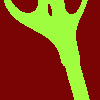

In [31]:
b.get_depth_image(gt_depth,min=0.0,max=intrinsics.far)

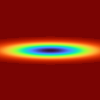

In [41]:
ball_parameters = jnp.array([
    [0.0, 0.0, 0.2, 1.0, 0.0, 0.0, 0.0, 0.012, 0.002, 0.002, 0.2],
    [0.0, 0.1, 0.4, 1.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.002, 0.3],
    [0.1, 0.1, 0.5, 1.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.002, 1.0],
    [0.0, 0.1, 0.6, 1.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.002, 1.0],
    [0.1, 0.1, 0.7, 1.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.002, 1.0],
    [0.1, 0.1, 0.8, 1.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.002, 1.0],
])
alphas = render_ball(ball_parameters)
b.get_depth_image(alphas)

Processing 0.029944: 100%|██████████| 2000/2000 [00:03<00:00, 511.73it/s]


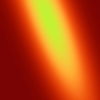

In [44]:
pbar = tqdm(range(2000))
for _ in pbar:
    loss_val, gradient_quat = value_and_grad_loss(ball_parameters, gt_depth)
    pbar.set_description("Processing %f" % loss_val.item())
    ball_parameters -= gradient_quat * 0.005
alphas = render_ball(ball_parameters)
b.get_depth_image(alphas,min=0.0,max=intrinsics.far)

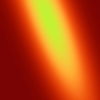

In [45]:
alphas = render_ball(ball_parameters)
b.clear()
b.show_cloud("1", unproject_depth(alphas, intrinsics).reshape(-1,3))
b.show_cloud("gt", unproject_depth(gt_depth, intrinsics).reshape(-1,3), color=b.RED)
b.get_depth_image(alphas,min=0.0,max=intrinsics.far)

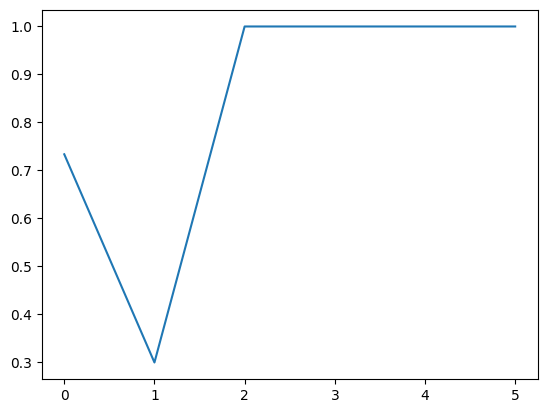

In [46]:
plt.plot(ball_parameters[:,-1])

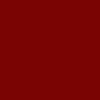

In [48]:
b.get_depth_image(render_ball(ball_parameters[2:]),min=0.0,max=intrinsics.far)

In [ ]:
plt.matshow(alphas)
plt.colorbar()

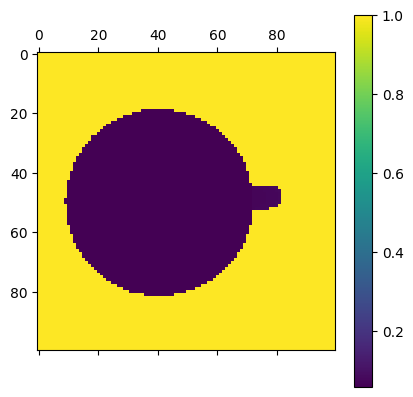

In [147]:
plt.matshow(gt_depth)
plt.colorbar()